# DSLWP tracking file analysis

In this notebook, we analyse the tracking files published for DSLWP using GMAT. The tracking files contain a listing of the position and velocity of the spacecraft in ECEF coordinates for each second. For each tracking file, a GMAT script is generated using the information in the first entry of the tracking file as the spacecraft's orbital elements. The spacecraft is propagated using a step of one second for the duration of the tracking file and the error in the position is compared between the tracking file and the GMAT propagation.

In [1]:
%matplotlib inline

Set this to the path of your GMAT executable:

In [2]:
GMAT_PATH = '/home/daniel/GMAT/R2018a/bin/GMAT-R2018a'

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import subprocess

# Larger figure size
fig_size = [10, 6]
plt.rcParams['figure.figsize'] = fig_size

The GMAT script template contains fields ready to be filled in using Python's `format()` function.

In [4]:
gmat_script_template = """
%----------------------------------------
%---------- Spacecraft
%----------------------------------------

Create Spacecraft DSLWP_B;
GMAT DSLWP_B.DateFormat = UTCModJulian;
GMAT DSLWP_B.Epoch = '{epoch}';
GMAT DSLWP_B.CoordinateSystem = EarthFixed;
GMAT DSLWP_B.DisplayStateType = Cartesian;
GMAT DSLWP_B.X = {x};
GMAT DSLWP_B.Y = {y};
GMAT DSLWP_B.Z = {z};
GMAT DSLWP_B.VX = {vx};
GMAT DSLWP_B.VY = {vy};
GMAT DSLWP_B.VZ = {vz};
GMAT DSLWP_B.DryMass = 45;
GMAT DSLWP_B.Cd = 2.2;
GMAT DSLWP_B.Cr = 1.8;
GMAT DSLWP_B.DragArea = 0.25;
GMAT DSLWP_B.SRPArea = 0.25;
GMAT DSLWP_B.NAIFId = -10000001;
GMAT DSLWP_B.NAIFIdReferenceFrame = -9000001;
GMAT DSLWP_B.OrbitColor = Red;
GMAT DSLWP_B.TargetColor = Teal;
GMAT DSLWP_B.OrbitErrorCovariance = [ 1e+70 0 0 0 0 0 ; 0 1e+70 0 0 0 0 ; 0 0 1e+70 0 0 0 ; 0 0 0 1e+70 0 0 ; 0 0 0 0 1e+70 0 ; 0 0 0 0 0 1e+70 ];
GMAT DSLWP_B.CdSigma = 1e+70;
GMAT DSLWP_B.CrSigma = 1e+70;
GMAT DSLWP_B.Id = 'SatId';
GMAT DSLWP_B.Attitude = CoordinateSystemFixed;
GMAT DSLWP_B.SPADSRPScaleFactor = 1;
GMAT DSLWP_B.ModelFile = 'aura.3ds';
GMAT DSLWP_B.ModelOffsetX = 0;
GMAT DSLWP_B.ModelOffsetY = 0;
GMAT DSLWP_B.ModelOffsetZ = 0;
GMAT DSLWP_B.ModelRotationX = 0;
GMAT DSLWP_B.ModelRotationY = 0;
GMAT DSLWP_B.ModelRotationZ = 0;
GMAT DSLWP_B.ModelScale = 1;
GMAT DSLWP_B.AttitudeDisplayStateType = 'Quaternion';
GMAT DSLWP_B.AttitudeRateDisplayStateType = 'AngularVelocity';
GMAT DSLWP_B.AttitudeCoordinateSystem = EarthMJ2000Eq;
GMAT DSLWP_B.EulerAngleSequence = '321';


%----------------------------------------
%---------- ForceModels
%----------------------------------------

Create ForceModel EarthProp_ForceModel;
GMAT EarthProp_ForceModel.CentralBody = Earth;
GMAT EarthProp_ForceModel.PrimaryBodies = {{Earth}};
GMAT EarthProp_ForceModel.PointMasses = {{Jupiter, Luna, Mars, Neptune, Saturn, Sun, Uranus, Venus}};
GMAT EarthProp_ForceModel.SRP = On;
GMAT EarthProp_ForceModel.RelativisticCorrection = On;
GMAT EarthProp_ForceModel.ErrorControl = RSSStep;
GMAT EarthProp_ForceModel.GravityField.Earth.Degree = 10;
GMAT EarthProp_ForceModel.GravityField.Earth.Order = 10;
GMAT EarthProp_ForceModel.GravityField.Earth.StmLimit = 100;
GMAT EarthProp_ForceModel.GravityField.Earth.PotentialFile = 'JGM2.cof';
GMAT EarthProp_ForceModel.GravityField.Earth.TideModel = 'None';
GMAT EarthProp_ForceModel.SRP.Flux = 1367;
GMAT EarthProp_ForceModel.SRP.SRPModel = Spherical;
GMAT EarthProp_ForceModel.SRP.Nominal_Sun = 149597870.691;
GMAT EarthProp_ForceModel.Drag.AtmosphereModel = JacchiaRoberts;
GMAT EarthProp_ForceModel.Drag.HistoricWeatherSource = 'ConstantFluxAndGeoMag';
GMAT EarthProp_ForceModel.Drag.PredictedWeatherSource = 'ConstantFluxAndGeoMag';
GMAT EarthProp_ForceModel.Drag.CSSISpaceWeatherFile = 'SpaceWeather-All-v1.2.txt';
GMAT EarthProp_ForceModel.Drag.SchattenFile = 'SchattenPredict.txt';
GMAT EarthProp_ForceModel.Drag.F107 = 150;
GMAT EarthProp_ForceModel.Drag.F107A = 150;
GMAT EarthProp_ForceModel.Drag.MagneticIndex = 3;
GMAT EarthProp_ForceModel.Drag.SchattenErrorModel = 'Nominal';
GMAT EarthProp_ForceModel.Drag.SchattenTimingModel = 'NominalCycle';

Create ForceModel LunaProp_ForceModel;
GMAT LunaProp_ForceModel.CentralBody = Luna;
GMAT LunaProp_ForceModel.PrimaryBodies = {{Luna}};
GMAT LunaProp_ForceModel.PointMasses = {{Earth, Jupiter, Mars, Neptune, Saturn, Sun, Uranus, Venus}};
GMAT LunaProp_ForceModel.Drag = None;
GMAT LunaProp_ForceModel.SRP = On;
GMAT LunaProp_ForceModel.RelativisticCorrection = On;
GMAT LunaProp_ForceModel.ErrorControl = RSSStep;
GMAT LunaProp_ForceModel.GravityField.Luna.Degree = 10;
GMAT LunaProp_ForceModel.GravityField.Luna.Order = 10;
GMAT LunaProp_ForceModel.GravityField.Luna.StmLimit = 100;
GMAT LunaProp_ForceModel.GravityField.Luna.PotentialFile = 'LP165P.cof';
GMAT LunaProp_ForceModel.GravityField.Luna.TideModel = 'None';
GMAT LunaProp_ForceModel.SRP.Flux = 1367;
GMAT LunaProp_ForceModel.SRP.SRPModel = Spherical;
GMAT LunaProp_ForceModel.SRP.Nominal_Sun = 149597870.691;

Create ForceModel SimpleLunaProp_ForceModel;
GMAT SimpleLunaProp_ForceModel.CentralBody = Luna;
GMAT SimpleLunaProp_ForceModel.PrimaryBodies = {{Luna}};
GMAT SimpleLunaProp_ForceModel.PointMasses = {{Earth}};
GMAT SimpleLunaProp_ForceModel.Drag = None;
GMAT SimpleLunaProp_ForceModel.SRP = Off;
GMAT SimpleLunaProp_ForceModel.RelativisticCorrection = Off;
GMAT SimpleLunaProp_ForceModel.ErrorControl = RSSStep;
GMAT SimpleLunaProp_ForceModel.GravityField.Luna.Degree = {simpleluna_degree};
GMAT SimpleLunaProp_ForceModel.GravityField.Luna.Order = {simpleluna_order};
GMAT SimpleLunaProp_ForceModel.GravityField.Luna.StmLimit = 100;
GMAT SimpleLunaProp_ForceModel.GravityField.Luna.PotentialFile = 'LP165P.cof';
GMAT SimpleLunaProp_ForceModel.GravityField.Luna.TideModel = 'None';

%----------------------------------------
%---------- Propagators
%----------------------------------------

Create Propagator EarthProp;
GMAT EarthProp.FM = EarthProp_ForceModel;
GMAT EarthProp.Type = RungeKutta89;
GMAT EarthProp.InitialStepSize = 1;
GMAT EarthProp.Accuracy = 9.999999999999999e-12;
GMAT EarthProp.MinStep = 1;
GMAT EarthProp.MaxStep = 1;
GMAT EarthProp.MaxStepAttempts = 50;
GMAT EarthProp.StopIfAccuracyIsViolated = true;

Create Propagator LunaProp;
GMAT LunaProp.FM = LunaProp_ForceModel;
GMAT LunaProp.Type = RungeKutta89;
GMAT LunaProp.InitialStepSize = 1;
GMAT LunaProp.Accuracy = 9.999999999999999e-12;
GMAT LunaProp.MinStep = 1;
GMAT LunaProp.MaxStep = 1;
GMAT LunaProp.MaxStepAttempts = 50;
GMAT LunaProp.StopIfAccuracyIsViolated = true;

Create Propagator SimpleLunaProp;
GMAT SimpleLunaProp.FM = SimpleLunaProp_ForceModel;
GMAT SimpleLunaProp.Type = RungeKutta89;
GMAT SimpleLunaProp.InitialStepSize = 1;
GMAT SimpleLunaProp.Accuracy = 9.999999999999999e-12;
GMAT SimpleLunaProp.MinStep = 1;
GMAT SimpleLunaProp.MaxStep = 1;
GMAT SimpleLunaProp.MaxStepAttempts = 50;
GMAT SimpleLunaProp.StopIfAccuracyIsViolated = true;

%----------------------------------------
%---------- Coordinate Systems
%----------------------------------------

Create CoordinateSystem LunaInertial;
GMAT LunaInertial.Origin = Luna;
GMAT LunaInertial.Axes = BodyInertial;

%----------------------------------------
%---------- Subscribers
%----------------------------------------

Create OrbitView EarthLunaView;
GMAT EarthLunaView.SolverIterations = None;
GMAT EarthLunaView.UpperLeft = [ 0.1801470588235294 0.04190751445086705 ];
GMAT EarthLunaView.Size = [ 0.9926470588235294 0.9552023121387283 ];
GMAT EarthLunaView.RelativeZOrder = 123;
GMAT EarthLunaView.Maximized = true;
GMAT EarthLunaView.Add = {{DSLWP_B, Earth, Luna, Sun}};
GMAT EarthLunaView.CoordinateSystem = EarthMJ2000Eq;
GMAT EarthLunaView.DrawObject = [ true true true true ];
GMAT EarthLunaView.DataCollectFrequency = 60;
GMAT EarthLunaView.UpdatePlotFrequency = 50;
GMAT EarthLunaView.NumPointsToRedraw = 0;
GMAT EarthLunaView.ShowPlot = true;
GMAT EarthLunaView.MaxPlotPoints = 20000;
GMAT EarthLunaView.ShowLabels = true;
GMAT EarthLunaView.ViewPointReference = Earth;
GMAT EarthLunaView.ViewPointVector = [ 0 0 30000 ];
GMAT EarthLunaView.ViewDirection = Earth;
GMAT EarthLunaView.ViewScaleFactor = 40;
GMAT EarthLunaView.ViewUpCoordinateSystem = EarthMJ2000Eq;
GMAT EarthLunaView.ViewUpAxis = Z;
GMAT EarthLunaView.EclipticPlane = Off;
GMAT EarthLunaView.XYPlane = On;
GMAT EarthLunaView.WireFrame = Off;
GMAT EarthLunaView.Axes = On;
GMAT EarthLunaView.Grid = Off;
GMAT EarthLunaView.SunLine = Off;
GMAT EarthLunaView.UseInitialView = On;
GMAT EarthLunaView.StarCount = 7000;
GMAT EarthLunaView.EnableStars = On;
GMAT EarthLunaView.EnableConstellations = Off;

Create OrbitView LunaOrbitView;
GMAT LunaOrbitView.SolverIterations = None;
GMAT LunaOrbitView.UpperLeft = [ 0.1801470588235294 0.04190751445086705 ];
GMAT LunaOrbitView.Size = [ 0.9926470588235294 0.9552023121387283 ];
GMAT LunaOrbitView.RelativeZOrder = 126;
GMAT LunaOrbitView.Maximized = true;
GMAT LunaOrbitView.Add = {{DSLWP_B, Earth, Luna, Sun}};
GMAT LunaOrbitView.CoordinateSystem = LunaInertial;
GMAT LunaOrbitView.DrawObject = [ true true true true ];
GMAT LunaOrbitView.DataCollectFrequency = 60;
GMAT LunaOrbitView.UpdatePlotFrequency = 50;
GMAT LunaOrbitView.NumPointsToRedraw = 0;
GMAT LunaOrbitView.ShowPlot = true;
GMAT LunaOrbitView.MaxPlotPoints = 20000;
GMAT LunaOrbitView.ShowLabels = true;
GMAT LunaOrbitView.ViewPointReference = Luna;
GMAT LunaOrbitView.ViewPointVector = [ 30000 0 0 ];
GMAT LunaOrbitView.ViewDirection = Luna;
GMAT LunaOrbitView.ViewScaleFactor = 1;
GMAT LunaOrbitView.ViewUpCoordinateSystem = LunaInertial;
GMAT LunaOrbitView.ViewUpAxis = Z;
GMAT LunaOrbitView.EclipticPlane = Off;
GMAT LunaOrbitView.XYPlane = On;
GMAT LunaOrbitView.WireFrame = Off;
GMAT LunaOrbitView.Axes = On;
GMAT LunaOrbitView.Grid = Off;
GMAT LunaOrbitView.SunLine = Off;
GMAT LunaOrbitView.UseInitialView = On;
GMAT LunaOrbitView.StarCount = 7000;
GMAT LunaOrbitView.EnableStars = On;
GMAT LunaOrbitView.EnableConstellations = Off;

Create ReportFile ECEFReport;
GMAT ECEFReport.SolverIterations = Current;
GMAT ECEFReport.UpperLeft = [ 0 0 ];
GMAT ECEFReport.Size = [ 0 0 ];
GMAT ECEFReport.RelativeZOrder = 0;
GMAT ECEFReport.Maximized = false;
GMAT ECEFReport.Filename = '/home/daniel/jupyter_notebooks/dslwp/ECEFReport_{label}.txt';
GMAT ECEFReport.Precision = 16;
GMAT ECEFReport.Add = {{DSLWP_B.UTCModJulian, DSLWP_B.EarthFixed.X, DSLWP_B.EarthFixed.Y, DSLWP_B.EarthFixed.Z, DSLWP_B.EarthFixed.VX, DSLWP_B.EarthFixed.VY, DSLWP_B.EarthFixed.VZ}};
GMAT ECEFReport.WriteHeaders = false;
GMAT ECEFReport.LeftJustify = On;
GMAT ECEFReport.ZeroFill = Off;
GMAT ECEFReport.FixedWidth = true;
GMAT ECEFReport.Delimiter = ' ';
GMAT ECEFReport.ColumnWidth = 23;
GMAT ECEFReport.WriteReport = true;


%----------------------------------------
%---------- Mission Sequence
%----------------------------------------

BeginMissionSequence;
Propagate {propagator}(DSLWP_B) {{DSLWP_B.ElapsedSecs = {elapsed_secs}}};
"""

Conversion between UNIX timestamp (used by the tracking files) and GMAT Modified Julian Day.

In [5]:
mjd_unixtimestamp_offset = 10587.5
seconds_in_day = 3600 * 24

def mjd2unixtimestamp(m):
    return (m - mjd_unixtimestamp_offset) * seconds_in_day

def unixtimestamp2mjd(u):
    return u / seconds_in_day + mjd_unixtimestamp_offset

In [6]:
def load_tracking_file(path):
    ncols = 7
    data = np.fromfile(path, sep=' ')
    return data.reshape((data.size // ncols, ncols))

Error (distance) between the positions of two listings.

In [7]:
def error(a,b):
    return np.sqrt(np.sum((a[:,1:4] - b[:,1:4])**2, axis=1))

The function below takes the data from a tracking file, generates a GMAT script and executes it. GMAT is closed automatically after the script has run unless `do_not_close` is set to `True`. This can be useful to examine the simulation output in more detail.

In [8]:
def gmat_propagate_tracking(track, propagator, label = '',
                            simpleluna_degree = 0, simpleluna_order = 0, do_not_close = False):
    data = {'propagator' : propagator, 'label' : label,
            'simpleluna_degree' : simpleluna_degree, 'simpleluna_order' : simpleluna_order}
    data['epoch'] = unixtimestamp2mjd(track[0,0])
    data['elapsed_secs'] = track[-1,0] - track[0,0]
    data['x'], data['y'], data['z'] = track[0,1:4]
    data['vx'], data['vy'], data['vz'] = track[0,4:7]
    SCRIPT_PATH = '/tmp/gmat.script'
    with open(SCRIPT_PATH, 'w') as f:
        f.write(gmat_script_template.format(**data))
    subprocess.call([GMAT_PATH, '-r', SCRIPT_PATH] + (['-x'] if not do_not_close else []))

### First tracking file: 20 May 21:54:51 - 22 May 21:54:50

In [9]:
tracking = load_tracking_file('tracking_files/program_tracking_dslwp-a_20180520_window1.txt')

In [10]:
gmat_propagate_tracking(tracking, propagator = 'EarthProp', label = 'part1')

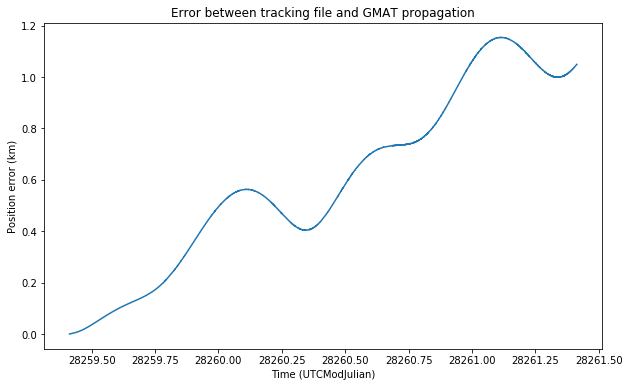

In [11]:
propagation = load_tracking_file('ECEFReport_part1.txt')
plt.plot(propagation[:,0], error(tracking[:-1,:], propagation))
plt.title('Error between tracking file and GMAT propagation')
plt.ylabel('Position error (km)')
plt.xlabel('Time (UTCModJulian)');

### Second tracking file: 26 May 00:00:00 - 27 May 23:59:59

In [12]:
tracking = load_tracking_file('tracking_files/program_tracking_dslwp-b_20180526.txt')

In [13]:
gmat_propagate_tracking(tracking, propagator = 'LunaProp', label = 'part2')

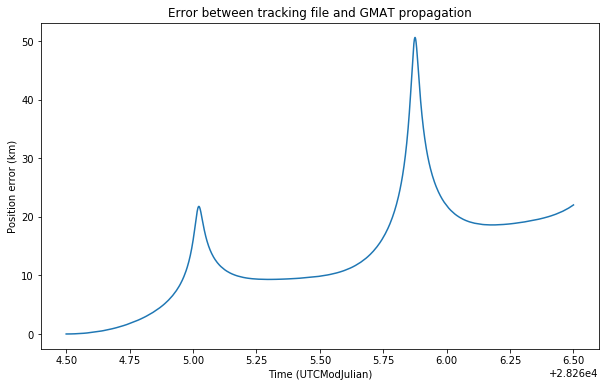

In [14]:
propagation = load_tracking_file('ECEFReport_part2.txt')
plt.plot(propagation[:,0], error(tracking, propagation))
plt.title('Error between tracking file and GMAT propagation')
plt.ylabel('Position error (km)')
plt.xlabel('Time (UTCModJulian)');

### Third tracking file: 28 May 00:00:00 - 29 May 23:59:59

In [15]:
tracking = load_tracking_file('tracking_files/program_tracking_dslwp-b_20180528.txt')

In [16]:
gmat_propagate_tracking(tracking, propagator = 'LunaProp', label = 'part3')

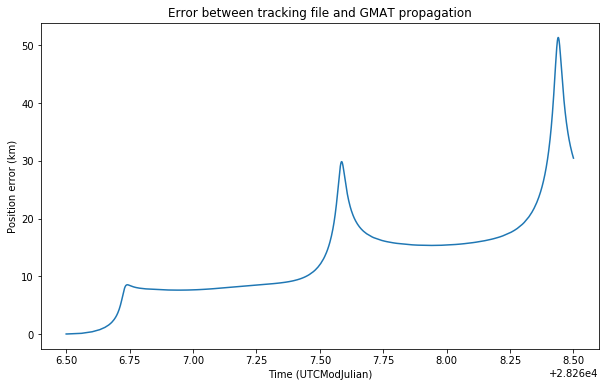

In [17]:
propagation = load_tracking_file('ECEFReport_part3.txt')
plt.plot(propagation[:,0], error(tracking, propagation))
plt.title('Error between tracking file and GMAT propagation')
plt.ylabel('Position error (km)')
plt.xlabel('Time (UTCModJulian)');

### Lunar force model tests (using second tracking file)

In [18]:
tracking = load_tracking_file('tracking_files/program_tracking_dslwp-b_20180526.txt')

In [19]:
deg_ords = [(0,0), (2,0), (2,1), (2,2), (3,0), (3,1), (3,2), (3,3)]

In [20]:
for degree, order in deg_ords:
    gmat_propagate_tracking(tracking, propagator = 'SimpleLunaProp', 
                            label = 'part2_simple_deg{}_ord{}'.format(degree,order),
                            simpleluna_degree = degree, simpleluna_order = order)

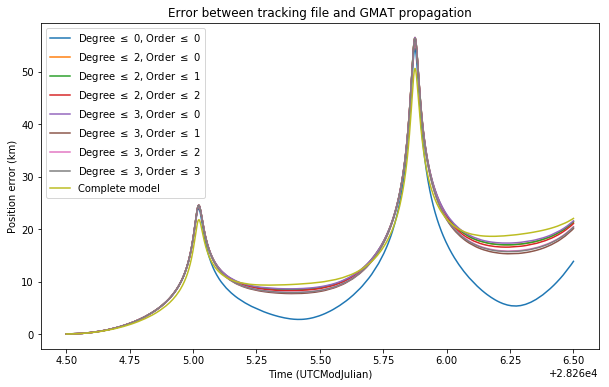

In [21]:
for degree, order in deg_ords:
    propagation = load_tracking_file('ECEFReport_part2_simple_deg{}_ord{}.txt'.format(degree,order))
    plt.plot(propagation[:,0], error(tracking, propagation))
propagation = load_tracking_file('ECEFReport_part2.txt')
plt.plot(propagation[:,0], error(tracking, propagation))
plt.title('Error between tracking file and GMAT propagation')
plt.ylabel('Position error (km)')
plt.xlabel('Time (UTCModJulian)')
plt.legend(['Degree $\leq$ {}, Order $\leq$ {}'.format(j,k) for j,k in deg_ords] + ['Complete model']);